# Popular Data Science Questions

Our goal in this project is to use [Data Science Stack Exchange](https://datascience.stackexchange.com/) to determine what content should a data science education company create, based on interest by subject.

## Stack exchange

**what kind of questions are welcome on this site?**

On DSSE's [help center's section on questions](https://datascience.stackexchange.com/help/asking) , we can read that we should:

- Avoid subjective questions.
- Ask practical questions about Data Science — there are adequate sites for theoretical questions.
- Ask specific questions.
- Make questions relevant to others.

All of these characteristics, if employed, should be helpful attributes to our goal.

In the help center we also learned that in addition to the sites mentioned in the *Learn* section, there are other two sites that are relevant:
- [Open Data](https://opendata.stackexchange.com/help/on-topic)
- [Computational Science](https://scicomp.stackexchange.com/help/on-topic)

**What, other than questions, does DSSE's [home](https://datascience.stackexchange.com/) subdivide into?**
On the home page we can see that we have four sections:

- [Questions](https://datascience.stackexchange.com/questions) — a list of all questions asked;
- [Tags](https://datascience.stackexchange.com/tags) — a list of tags (keywords or labels that categorize questions);
- [Users](https://datascience.stackexchange.com/users) — a list of users;
- [Unanswered](https://datascience.stackexchange.com/unanswered) — a list of unanswered questions;

The tagging system used by Stack Exchange looks just like what we need to solve this problem as it allow us to quantify how many questions are asked about each subject.

Something else we can learn from exploring the help center, is that Stack Exchange's sites are heavily moderated by the community; this gives us some confidence in using the tagging system to derive conclusions.

**What information is available in each post?**
Looking, just as an example, at [this question](https://datascience.stackexchange.com/questions/19141/linear-model-to-generate-probability-of-each-possible-output?rq=1), some of the information we see is:

- For both questions and answers:
  - The posts's score;
  - The posts's title;
  - The posts's author;
  - The posts's body;
- For questions only:
  - How many users have it on their "
  - The last time the question as active;
  - How many times the question was viewed;
  - Related questions;
  - The question's tags;
  
## [Stack exchange data explorer](https://data.stackexchange.com/datascience/query/edit/1431281)

Perusing the table names, a few stand out as relevant for our goal:

- Posts
- PostTags
- Tags
- TagSynonyms

Running a few exploratory queries, leads us to focus our efforts on Posts table. For examples, the Tags table looked very promising as it tells us how many times each tag was used, but there's no way to tell just from this if the interest in these tags is recent or a thing from the past.

## Getting the Data

To get the relevant data we run the following query.

>SELECT Id, CreationDate,<br>
       Score, ViewCount, Tags,<br>
       AnswerCount, FavoriteCount<br>
  FROM posts<br>
 WHERE PostTypeId = 1 AND YEAR(CreationDate) = 2021;
 
 
## Exploring the data
We can read in the data while immediately making sure CreationDate will be stored as a datetime object:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [2]:
questions = pd.read_csv("2020_questions.csv", parse_dates=["CreationDate"])
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6784 entries, 0 to 6783
Data columns (total 7 columns):
Id               6784 non-null int64
CreationDate     6784 non-null datetime64[ns]
Score            6784 non-null int64
ViewCount        6784 non-null int64
Tags             6784 non-null object
AnswerCount      6784 non-null int64
FavoriteCount    984 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 371.1+ KB



We see that only FavoriteCount has missing values. A missing value on this column probably means that the question was is not present in any users' favorite list, so we can replace the missing values with zero.

The types seem adequate for every column, however, after we fill in the missing values on FavoriteCount, there is no reason to store the values as floats.

# Cleaning the data

In [3]:
questions['FavoriteCount'].fillna(0, inplace=True)
questions['FavoriteCount'] = questions['FavoriteCount'].astype(int)

Since the object dtype is a catch-all type, let's see what types the objects in questions ["Tags"] are.

In [4]:
questions['Tags'].apply(lambda x: type(x)).unique()

array([<class 'str'>], dtype=object)

We see that every value in this column is a string. On Stack Exchange, each question can only have a maximum of five tags ([source](https://meta.stackexchange.com/questions/18878/how-do-i-correctly-tag-my-questions/18879#18879)), so one way to deal with this column is to create five columns in questions called Tag1, Tag2, Tag3, Tag4, and Tag5 and populate the columns with the tags in each row.

However, since doesn't help is relating tags from one question to another, we'll just keep them as a list.

In [5]:
questions['Tags'] = questions['Tags'].str.replace('^<|>$', '').str.split('><')
questions.sample(10)

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
5312,69726,2020-03-15 12:28:42,3,630,"[python, keras, tensorflow, one-hot-encoding]",1,2
1895,66055,2020-01-07 20:06:04,1,252,"[jupyter, pip]",1,0
839,75733,2020-06-09 19:50:16,2,439,"[machine-learning, scikit-learn, feature-selec...",2,1
6053,82766,2020-10-09 08:50:51,1,426,"[deep-learning, time-series, lstm, training, rnn]",1,0
5165,69506,2020-03-11 10:00:36,2,2443,"[machine-learning, gan, metric, generative-mod...",1,0
4178,80282,2020-08-14 13:32:30,0,15,"[machine-learning, deep-learning, nlp, sequence]",0,0
2801,85697,2020-11-20 10:49:10,0,14,"[machine-learning, nlp, text-mining, unsupervi...",0,0
3383,67051,2020-01-25 18:31:32,2,23,"[deep-learning, classification, time-series]",0,0
5757,70309,2020-03-27 09:57:37,1,55,"[deep-learning, time-series, regression]",1,0
6375,72217,2020-04-13 02:10:49,1,168,"[machine-learning, keras]",0,0


# Most used and most viewed

In [6]:
tags_count = dict()

for tags in questions['Tags']:
    for tag in tags:
        if tag in tags_count:
            tags_count[tag] += 1
        else:
            tags_count[tag] = 1

tags_count = pd.DataFrame.from_dict(tags_count, orient='index')
tags_count.rename({0:'Count'}, axis=1, inplace=True)
tags_count.head()

,Count
tensorflow,522
time-series,338
multilabel-classification,62
machine-learning,2039
python,1293


In [7]:
most_used = tags_count.sort_values('Count').tail(20)
most_used

,Count
feature-selection,186
predictive-modeling,193
r,202
clustering,225
statistics,232
pandas,254
lstm,268
dataset,274
cnn,317
regression,328



The threshold of 20 is somewhat arbitrary and we can experiment with others, however, popularity of the tags rapidly declines, so looking at these tags should be enough to help us with our goal. Let's visualize these data.

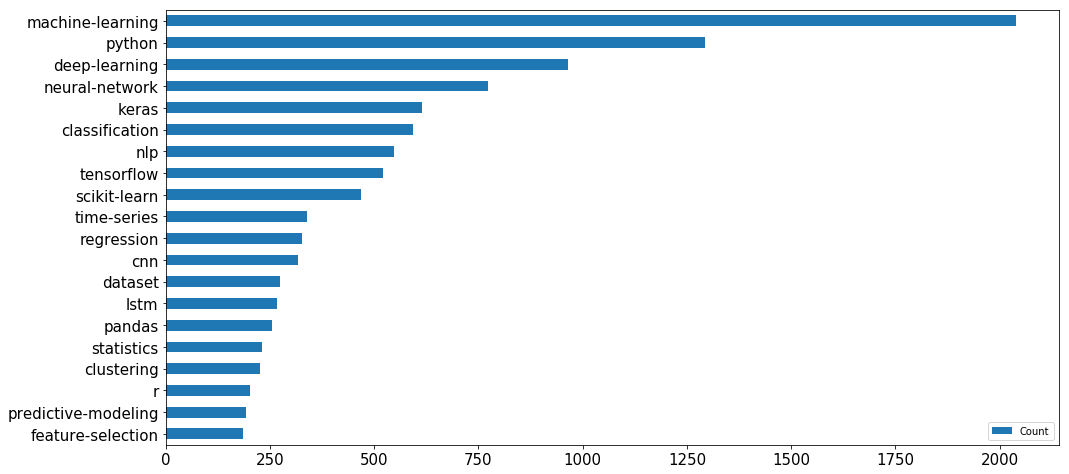

In [8]:
most_used.plot.barh(figsize=(16,8),fontsize=15)


Some tags are very, very broad and are unlikely to be useful; e.g.: python, dataset, r. Before we investigate the tags a little deeper, let's repeat the same process for views.

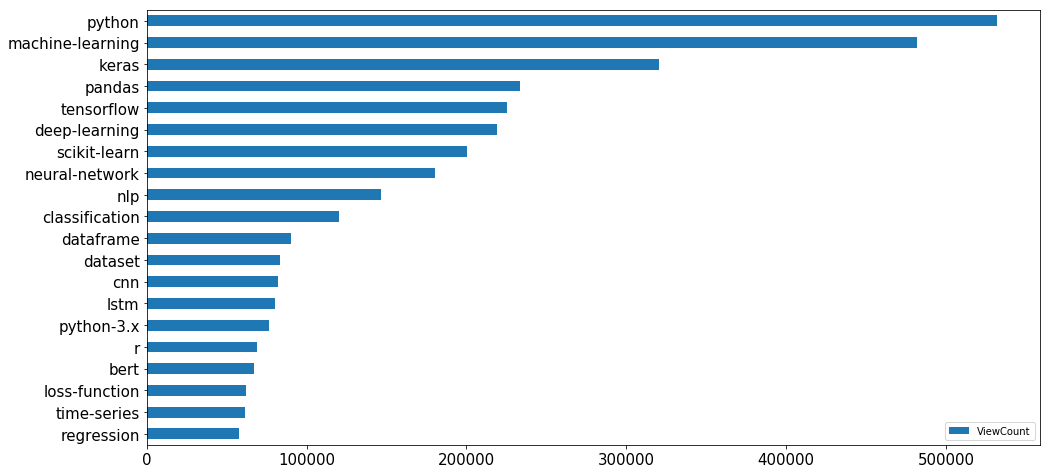

In [9]:
tags_view = dict()

for index, row in questions.iterrows():
    for tag in row['Tags']:
        if tag in tags_view:
            tags_view[tag] += row['ViewCount']
        else:
            tags_view[tag] = row['ViewCount']
            
tags_view = pd.DataFrame.from_dict(tags_view, orient='index')
tags_view.rename({0:'ViewCount'}, axis=1, inplace=True)
most_viewed = tags_view.sort_values('ViewCount').tail(20)
most_viewed.plot.barh(figsize=(16, 8),fontsize=15)

Let's see them side by side.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000024D42BC1630>],
      dtype=object)

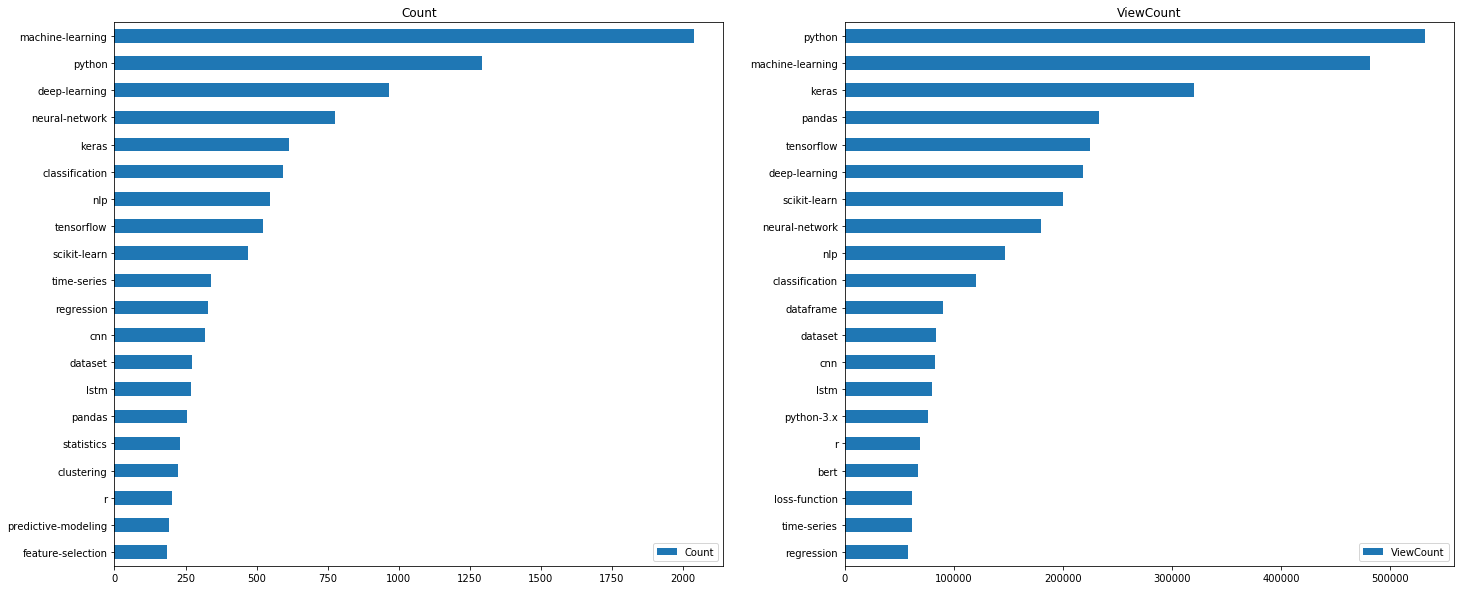

In [10]:
fig, axes=plt.subplots(nrows=1, ncols=2)
fig.set_size_inches((24,10))
most_used.plot(kind='barh', ax=axes[0], subplots=True)
most_viewed.plot(kind='barh', ax=axes[1], subplots=True)

# Relations between tags

In [11]:
in_used = pd.merge(most_used, most_viewed, how='left', left_index=True, right_index=True)
in_used

,Count,ViewCount
feature-selection,186,NaN
predictive-modeling,193,NaN
r,202,69228.0
clustering,225,NaN
statistics,232,NaN
pandas,254,233348.0
lstm,268,80331.0
dataset,274,83499.0
cnn,317,82451.0
regression,328,57858.0


In [12]:
in_viewed = pd.merge(most_used, most_viewed, how='right', left_index=True, right_index=True)
in_viewed

,Count,ViewCount
regression,328.0,57858
time-series,338.0,61306
loss-function,NaN,61824
bert,NaN,67398
r,202.0,69228
python-3.x,NaN,76530
lstm,268.0,80331
cnn,317.0,82451
dataset,274.0,83499
dataframe,NaN,90238


The tags present in most_used and not present in most_viewed are:

- clustering
- predictive-modeling
- r
- data-mining
- feature-selection

And the tags present in most_viewed but not in most_used are:

- numpy
- xgboost
- pytorch
- csv
- dataframe

Some tags also stand out as being related. For example, python is related to pandas, as we can find both pythons and pandas in the same country — or better yet, because pandas is a Python library. So by writing about pandas, we can actually simultaneously tackle two tags.

Other pairs of tags, shouldn't be related at all, like pandas and r. Luckily we don't have such a problem in this example.


And one way of trying to gauge how pairs of tags are related to each other, is to count how many times each pair appears together. Let's do this.

We'll begin by creating a list of all tags.

In [13]:
all_tags = list(tags_count.index)

We'll now create a dataframe where each row will represent a tag, and each column as well. Something like this:

| |tag1|tag2|tag3|
| --- | --- | --- | --- |
|tag1| | | |		
|tag2| | | |			
|tag3| | | |		

In [14]:
associations = pd.DataFrame(index=all_tags, columns=all_tags)
associations.iloc[0:4, 0:4]

,tensorflow,time-series,multilabel-classification,machine-learning
tensorflow,NaN,NaN,NaN,NaN
time-series,NaN,NaN,NaN,NaN
multilabel-classification,NaN,NaN,NaN,NaN
machine-learning,NaN,NaN,NaN,NaN


We will now fill this dataframe with zeroes and then, for each lists of tags in questions["Tags"], we will increment the intervening tags by one. The end result will be a dataframe that for each pair of tags, it tells us how many times they were used together.

In [15]:
associations.fillna(0, inplace=True)

for tag in questions['Tags']:
    associations.loc[tag, tag] += 1


This dataframe is quite large. Let's focus our attention on the most used tags. We'll add some colors to make it easier to talk about the dataframe. 

In [16]:
relations_most_used = associations.loc[most_used.index, most_used.index]
relations_most_used

,feature-selection,predictive-modeling,r,clustering,statistics,pandas,lstm,dataset,cnn,regression,time-series,scikit-learn,tensorflow,nlp,classification,keras,neural-network,deep-learning,python,machine-learning
feature-selection,186,6,5,6,7,6,3,6,1,8,2,21,0,5,9,2,15,14,28,71
predictive-modeling,6,193,5,7,18,3,5,10,1,24,24,8,3,2,27,2,10,14,37,88
r,5,5,202,11,13,1,2,10,0,15,10,0,2,6,11,6,11,2,24,50
clustering,6,7,11,225,3,2,0,5,0,4,8,19,3,12,20,0,2,4,48,52
statistics,7,18,13,3,232,3,2,14,0,18,15,6,3,6,15,1,8,17,28,88
pandas,6,3,1,2,3,254,2,20,0,3,13,26,0,8,2,3,2,0,155,23
lstm,3,5,2,0,2,2,268,2,13,7,68,0,35,24,7,81,49,77,36,64
dataset,6,10,10,5,14,20,2,274,7,12,17,9,14,16,21,10,16,27,35,82
cnn,1,1,0,0,0,0,13,7,317,5,10,3,50,4,18,78,75,122,36,76
regression,8,24,15,4,18,3,7,12,5,328,28,37,7,4,35,20,28,18,57,110


In [17]:
def style_cells(x):
    
    helper_df = pd.DataFrame('', index=x.index, columns=x.columns)
    helper_df.loc["time-series", "r"] = "background-color: yellow"
    helper_df.loc["r", "time-series"] = "background-color: yellow"
    
    for k in range(helper_df.shape[0]):
#         helper_df.iloc[k,k] = "color: blue"
        helper_df.iloc[k,k] = "background-color: red"
        
    return helper_df

relations_most_used.style.apply(style_cells, axis=None)

,feature-selection,predictive-modeling,r,clustering,statistics,pandas,lstm,dataset,cnn,regression,time-series,scikit-learn,tensorflow,nlp,classification,keras,neural-network,deep-learning,python,machine-learning
feature-selection,186,6,5,6,7,6,3,6,1,8,2,21,0,5,9,2,15,14,28,71
predictive-modeling,6,193,5,7,18,3,5,10,1,24,24,8,3,2,27,2,10,14,37,88
r,5,5,202,11,13,1,2,10,0,15,10,0,2,6,11,6,11,2,24,50
clustering,6,7,11,225,3,2,0,5,0,4,8,19,3,12,20,0,2,4,48,52
statistics,7,18,13,3,232,3,2,14,0,18,15,6,3,6,15,1,8,17,28,88
pandas,6,3,1,2,3,254,2,20,0,3,13,26,0,8,2,3,2,0,155,23
lstm,3,5,2,0,2,2,268,2,13,7,68,0,35,24,7,81,49,77,36,64
dataset,6,10,10,5,14,20,2,274,7,12,17,9,14,16,21,10,16,27,35,82
cnn,1,1,0,0,0,0,13,7,317,5,10,3,50,4,18,78,75,122,36,76
regression,8,24,15,4,18,3,7,12,5,328,28,37,7,4,35,20,28,18,57,110


The cells highlighted in yellow tell us that time-series was used together with r 18 times. The values in red tell us how many times each of the tags was used. We saw earlier that machine-learning was used 2136 times and we confirm it in this dataframe.

It's hard for a human to understand what is going on in this dataframe. Let's create a heatmap. But before we do it, let's get rid of the values in blue, otherwise the colors will be too skewed.

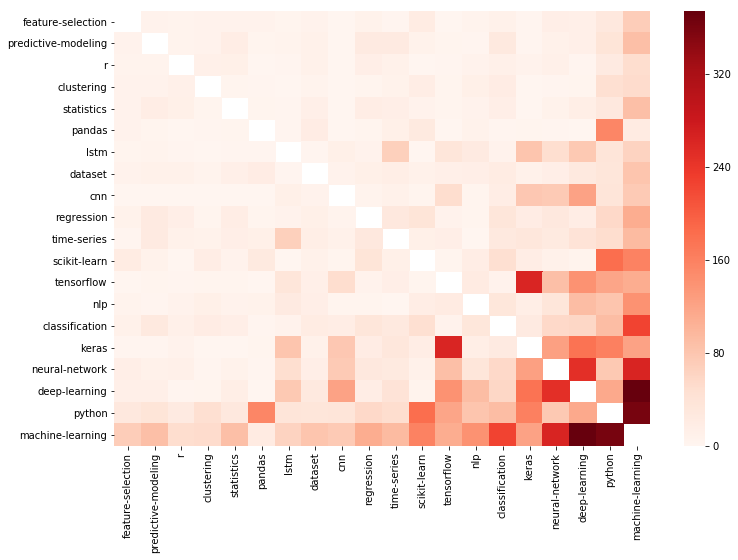

In [18]:
for k in range(relations_most_used.shape[0]):
    relations_most_used.iloc[k,k] = pd.np.nan

plt.figure(figsize=(12,8))
sns.heatmap(relations_most_used, cmap="Reds")

The most used tags also seem to have the strongest relationships, as given by the dark concentration in the bottom right corner. However, this could simply be because each of these tags is used a lot, and so end up being used together a lot without possibly even having any strong relation between them.

A more intuitive manifestation of this phenomenon is the following. A lot of people buy bread, a lot of people buy toilet paper, so they end up being purchased together a lot, but purchasing one of them doesn't increase the chances of purchasing the other.

Another shortcoming of this attempt is that it only looks at relations between pairs of tags and not between multiple groups of tags. For example, it could be the case that when used together, dataset and scikit-learn have a "strong" relation to pandas, but each by itself doesn't.

So how do we attack both these problems? There is a powerful data mining technique that allows us to handle this: [association rules](https://en.wikipedia.org/wiki/Association_rule_learning). Association rules allow us to analytically spot relations like "people who purchase milk, also purchase eggs". Moreover, we can also measure how strong this relations are on several fronts: how common the relation is, how strong it is, and how independent the components of the relationship are (toilet paper and bread are probably more independent than eggs and milk 

# Enter domain knowledge

[Keras](https://keras.io/), [scikit-learn](https://scikit-learn.org/stable/), [TensorFlow](https://www.tensorflow.org/) are all Python libraries that allow their users to employ deep learning (a type of neural network).

Most of the top tags are all intimately related with one central machine learning theme: deep learning. If we want to be very specific, we can suggest the creation of Python content that uses deep learning for classification problems (and other variations of this suggestion).

At the glance of an eye, someone with sufficient domain knowledge can tell that the most popular topic at the moment, as shown by our analysis, is deep learning.

# Just a fad?

Before we officially make our recommendation, it would be nice to solidify our findings with additional proof. More specifically, one thing that comes to mind is "Is deep learning just a fad?" Ideally, the content we decide to create will be the most useful for as long as possible. Could interest in deep learning be slowing down? Back to SEDE!

The query below will help us to fetches all of the questions ever asked on DSSE, their dates and tags. 

>SELECT Id, CreationDate, Tags <br>
  FROM posts<br>
 WHERE PostTypeId = 1;


In [19]:
all_q = pd.read_csv('all_questions.csv', parse_dates=['CreationDate'])
all_q['Tags'] = all_q['Tags'].str.replace('^<|>$', '').str.split('><')
all_q.head()

,Id,CreationDate,Tags
0,16191,2017-01-09 01:02:22,"[machine-learning, neural-network]"
1,16205,2017-01-09 11:22:46,"[python, logistic-regression, tensorflow]"
2,16206,2017-01-09 13:37:51,"[machine-learning, statistics, experiments]"
3,16207,2017-01-09 14:07:54,"[named-entity-recognition, stanford-nlp]"
4,16218,2017-01-10 02:43:10,"[machine-learning, neural-network, classificat..."


In [20]:
all_q.tail()

,Id,CreationDate,Tags
29458,97411,2021-07-03 15:04:30,"[machine-learning, scikit-learn, k-nn]"
29459,97416,2021-07-03 16:57:44,"[class-imbalance, auc, score]"
29460,97417,2021-07-03 17:13:58,"[deep-learning, cnn, multiclass-classification]"
29461,97420,2021-07-03 19:26:28,"[machine-learning, neural-network, perceptron]"
29462,97423,2021-07-03 20:33:35,"[machine-learning, deep-learning]"



Before deciding which questions should be classified as being deep learning questions, we should decide what tags are deep learning tags.

The definition of what constitutes a deep learning tag we'll use is: a tag that belongs to the list ["lstm", "cnn", "scikit-learn", "tensorflow", "keras", "neural-network", "deep-learning"].

This list was obtained by looking at all the tags in most_used and seeing which ones had any relation to deep learning. 

We'll now create a function that assigns 1 to deep learning questions and 0 otherwise; and we use it.

In [21]:
dl = ["lstm", "cnn", "scikit-learn", "tensorflow", "keras", "neural-network", "deep-learning"]

def class_deep_learning(tags):
    for tag in tags:
        if tag in dl:
            return 1
    return 0

all_q['DeepLearning'] = all_q['Tags'].apply(class_deep_learning)
all_q.sample(5)

,Id,CreationDate,Tags,DeepLearning
5496,30826,2018-04-25 15:19:28,"[unsupervised-learning, kernel]",0
462,73908,2020-05-10 07:33:18,"[multilabel-classification, metric, ranking, n...",0
27334,26840,2018-01-19 17:46:00,"[neural-network, convolutional-neural-network]",1
13858,32728,2018-06-06 10:56:35,"[machine-learning, lstm, audio-recognition, tf...",1
28855,14989,2016-11-07 23:14:08,"[machine-learning, regression, feature-selection]",0


The data-science-techonology landscape isn't something as dynamic to merit daily, weekly, or even monthly tracking. Let's track it quarterly.

Since we don't have all the data for the first quarter of 2021, we'll get rid of those dates:

In [22]:
all_q = all_q[all_q['CreationDate'].dt.year < 2021]

def fetch_quarter(datetime):
    year = str(datetime.year)[-2:]
    quarter = str((datetime.month - 1)//3 + 1)
    return "{y}q{q}".format(y=year, q=quarter)

all_q['Quarter'] = all_q['CreationDate'].apply(fetch_quarter)
all_q.sample(5)

,Id,CreationDate,Tags,DeepLearning,Quarter
2942,29788,2018-04-01 19:37:57,"[visualization, software-development, data-ana...",0,18q2
11066,75,2014-05-15 00:26:11,"[statistics, bigdata]",0,14q2
26924,84442,2020-10-24 09:41:15,"[keras, tensorflow]",1,20q4
16325,45157,2019-02-06 10:58:23,"[data, preprocessing]",0,19q1
6156,87162,2020-12-26 15:31:52,"[machine-learning, python, regression, linear-...",0,20q4



For the final stretch of this screen, we'll group by quarter and:

- Count the number of deep learning questions.
- Count the total number of questions.
- Compute the ratio between the two numbers above.

In [23]:
# quarterly = pd.pivot_table(all_q, index='Quarter', values='DeepLearning', aggfunc=[np.sum, np.size])
quarterly = all_q.groupby('Quarter').agg({'DeepLearning': ['sum', 'size']})

quarterly.columns = ['DeepLearningQuestions', 'TotalQuestions']
quarterly['DeepLearningRate'] = quarterly['DeepLearningQuestions']\
                                /quarterly['TotalQuestions']
quarterly.reset_index(inplace=True)
quarterly.head()  

,Quarter,DeepLearningQuestions,TotalQuestions,DeepLearningRate
0,14q2,9,157,0.057325
1,14q3,13,188,0.069149
2,14q4,21,214,0.098131
3,15q1,17,188,0.090426
4,15q2,28,284,0.098592


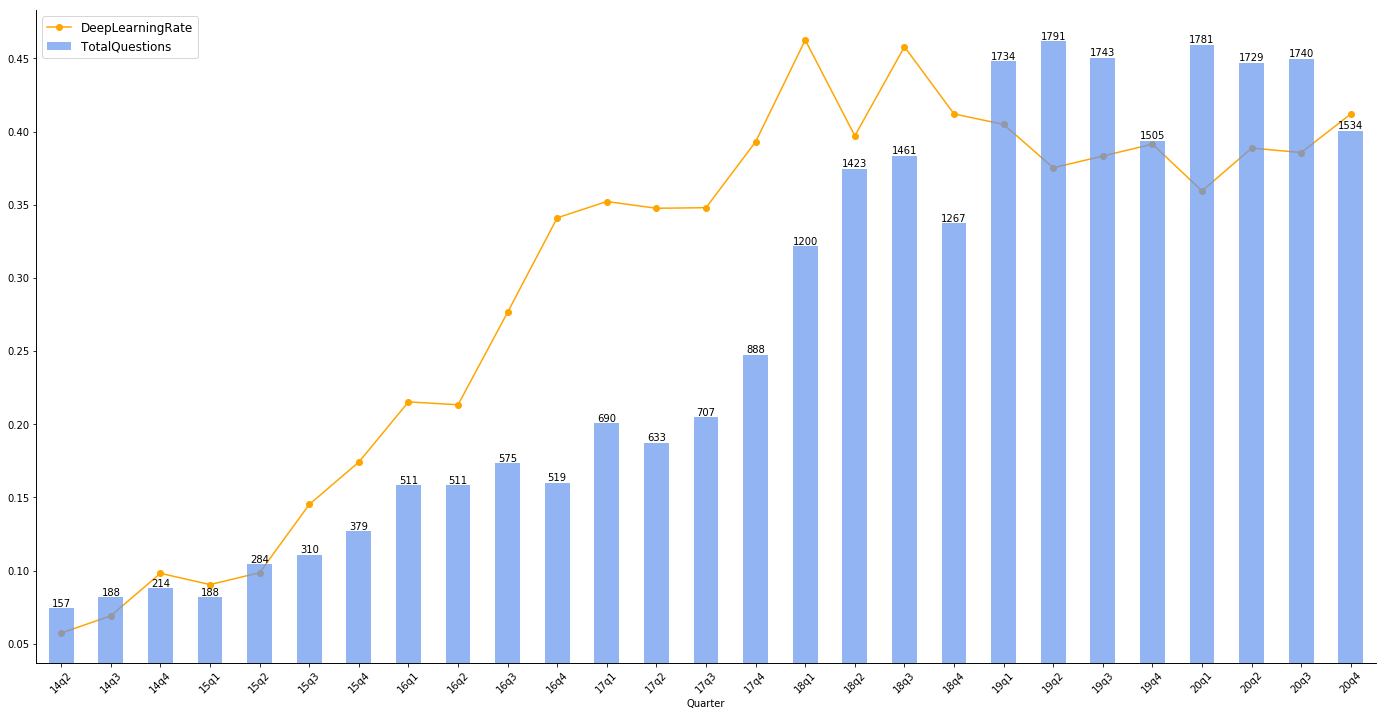

In [24]:
ax1 = quarterly.plot(x='Quarter', y='DeepLearningRate', kind='line', linestyle='-', marker='o', color='orange', figsize=(24,12))

ax2 = quarterly.plot(x='Quarter', y='TotalQuestions', kind='bar', ax=ax1, color='#6495ED', secondary_y=True, alpha=0.7, rot=45)

for index, row in quarterly['TotalQuestions'].iteritems():
    ax2.text(index, row, str(row), ha='center', va='bottom')
    
xlims = ax1.get_xlim()

ax1.get_legend().remove()
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles = handles1 + handles2, 
           labels = labels1 + labels2,
           loc='upper left', prop={'size': 12})

for ax in (ax1, ax2):
    for where in ('top', 'right'):
        ax.spines[where].set_visible(False)
        ax.tick_params(right=False, labelright=False)

It seems that deep learning questions was a high-growth trend since the start of DSSE and it looks like it is plateauing. There is no evidence to suggest that interest in deep learning is decreasing and so we maintain our previous idea of proposing that we create deep learning content.